# Introduction

The timeseries module provides the TimeSeries class which deals with all 1D timeseries (sizedistribution timeseries are considered 2D timeseries and are delt with in a different place). Usually when reading in any type of data, that is in some way a time series it will end up beeing a TimeSeries instance. Data in a TimeSeries is stored at TimeSeries.data in form of a pandas DataFrame instance.

# Imports

In [1]:
from atmPy.general import timeseries
from atmPy.aerosols.instruments.POPS import housekeeping
from atmPy.aerosols.instruments.piccolo import piccolo
from atmPy.data_archives.arm import read_data

In [2]:
# %matplotlib nbagg
%matplotlib inline

# Averaging

In [4]:
read_data.arm_products.keys()

dict_keys(['tdmaapssize', 'noaaaos', 'aosacsm', 'tdmahyg', '1twr10xC1', 'aipfitrh1ogrenC1', 'tdmasize'])

In [5]:
fname = '/Users/htelg/data/ARM/SGP/'
out = read_data.read_cdf(fname, data_product=['noaaaos'], 
                         time_window=('2012-02-01','2012-02-03'), 
                         data_quality='patchy')
noaaaos = out['noaaaos']

In [6]:
scatt = noaaaos.scatt_coeff._del_all_columns_but('Bs_G_Dry_1um_Neph3W_1')

In [7]:
scatt_avg = scatt.average_time((3,'h'))
scatt_avg_n = scatt.average_time_new((3,'h'))

In [8]:
scatt_align = scatt.align_to(scatt_avg)
scatt_align_n = scatt.align_to_new(scatt_avg_n)

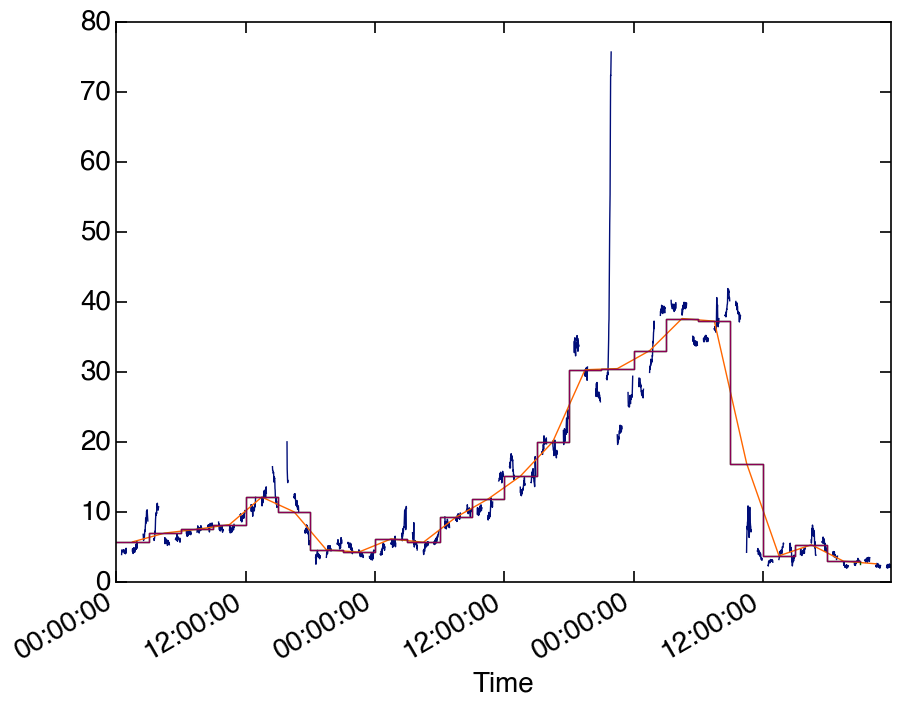

In [10]:
f,a = plt.subplots()
scatt.plot(ax = a)
scatt_avg.plot(ax = a)
scatt_avg_n.plot(ax = a)
g = a.get_lines()[-1]
g.set_drawstyle('steps-post')

# scatt_align.plot(ax = a)
scatt_align_n.plot(ax = a)
g = a.get_lines()[-1]
g.set_drawstyle('steps-post')

## rolling time lage correlation

In [3]:
read_data.arm_products.keys()

dict_keys(['noaaaos', 'aosacsm', 'tdmaapssize', 'tdmahyg', '1twr10xC1', 'aipfitrh1ogrenC1', 'tdmasize'])

In [4]:
fname = '/Users/htelg/data/ARM/SGP/'
out = read_data.read_cdf(fname, data_product=['tdmaapssize', 'aosacsm'], 
                         time_window=('2012-02-01','2012-02-10'), 
                         data_quality='patchy')
tdma = out['tdmaapssize']
acsm = out['aosacsm']

In [5]:
tv = tdma.size_distribution.particle_volume_concentration
av = acsm.mass_concentrations._del_all_columns_but('total') 

In [6]:
roll = tv.rolling(av,(5,'D'))
tlc_max, tlc_tlc = roll.timelaps_correlation(no_of_steps=20)

Each window contains 172 data points of which at least 115 are not nan.


/Users/htelg/prog/atm-py/atmPy/general/timeseries.py:409: FutureWarning: TimeSeries is deprecated. Please use Series
  self._timestamps = _pd.TimeSeries(_pd.to_datetime(_pd.Series(_np.zeros(self._size))))


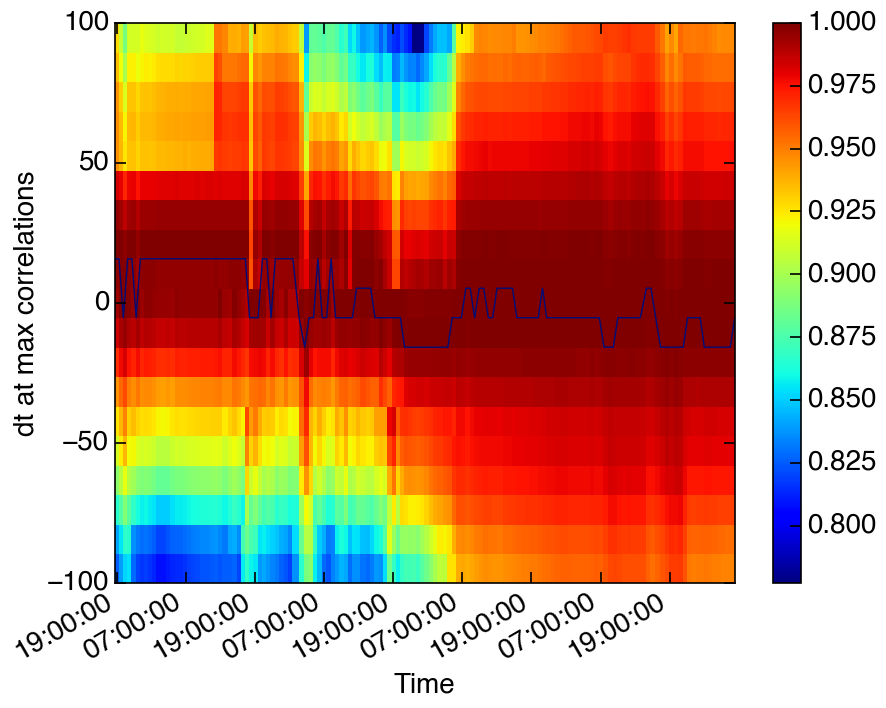

In [7]:
f,a,_,_ = tlc_tlc.plot()
tlc_max.plot(ax = a)

In [20]:
%%timeit
a = np.zeros(3) * np.nan
a

The slowest run took 9.17 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.37 µs per loop


In [21]:
%%timeit
a = np.zeros(3)
a[:] = np.nan
a

The slowest run took 9.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.48 µs per loop


In [14]:
a

array([ nan,  nan,  nan])

# Load/save

## netCDF

In [ ]:
fname = '/Users/htelg/data/ARM/SGP/sgpnoaaaosC1.b1.20120102.000000.cdf'
ts = read_data.read_cdf(fname).scatt_coeff

In [ ]:
ts = ts._del_all_columns_but('Bs_G_Dry_1um_Neph3W_1')

In [ ]:
ts.plot()

## csv

Usually a TimeSeries is generated when data representing a timeseries is loaded, e.g. POPS housekeeping data, or piccolo telemetry data.

In [3]:
pops_hk = housekeeping.read_csv('./data/POPS_housekeeping.csv')
picco_tel = piccolo.read_csv('./data/piccolo.log')

reading ./data/POPS_housekeeping.csv


# Features

## Plotting

In [ ]:
fname = '/Users/htelg/data/ARM/SGP/sgpnoaaaosC1.b1.20120102.0000'
ts = read_data.read_cdf(fname).scatt_coeff

In [ ]:
ts = ts._del_all_columns_but('Bs_G_Dry_1um_Neph3W_1')

In [ ]:
ts.plot()

In [ ]:
bla = ts.plot_wrapped(period=5, max_wraps=23)

## merge TimeSeries instances with different time axes

This attribute of a TimeSeries class allows the projection of a different instance on the current one. The resulting instance will have the collumns of both instances but with the time axes according to the first instance.

In [ ]:
pops_hk_merged = pops_hk.merge(picco_tel)
# pops_hk_merged.data

After merging it is possible to plot for example the Particle rate as a function of altitude. Columns which where previously in different Timeseries with different time intervals and time values.

In [ ]:
f,ax = plt.subplots()
ax.plot(pops_hk_merged.data.Particle_rate_nops, pops_hk_merged.data.Altitude)
ax.set_ylabel('Altitude (m)')
ax.set_xlabel('Particle rate (#/s)')

## Plot on map (probably not working right now)

When a TimeSeries instance has data columns named 'Lat' and 'Lon' it is possible to do a quick drowing of e.g. fligh path on a map. This uses matplotlib basemap.

In [ ]:
pops_hk_merged.plot_map(resolution = 'f')

# correlate time series

In [ ]:
data_product = ['aosacsm', 'noaaaos']
time_window=('2012-01-01', '2012-04-01')
folder = '/Users/htelg/data/ARM/SGP/'
out = read_data.read_cdf(folder, data_product=data_product, time_window=time_window, data_quality='good', verbose=False)

aosacsm = out['aosacsm']
noaaaos = out['noaaaos']

acsm_tm = timeseries.TimeSeries(pd.DataFrame(aosacsm.mass_concentrations.data['total']))
acsm_tm._data_period = aosacsm._data_period

noaa_scatt = timeseries.TimeSeries(pd.DataFrame(noaaaos.scatt_coeff.data['Bs_G_Dry_1um_Neph3W_1']))
noaa_scatt._data_period = noaaaos._data_period

In [ ]:
out = acsm_tm.correlate_to(noaa_scatt)
out.plot_pearsonANDoriginal_data()

In [ ]:
out = acsm_tm.rolling_correlation(noaa_scatt, (7,'D'))
out.plot()